In [1]:
import os
import numpy as np
from PIL import Image, ImageOps
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import json
import random

## Visualize datasets

In [2]:
import sys
sys.path.append('../')
from modules.datasets import TrainFoodDataset, TrainOutliersDataset, TestDataset, view_image

In [3]:
from torch.utils.data import DataLoader

train_food_dataset = TrainFoodDataset('../data/')
train_food_dataloader = DataLoader(train_food_dataset, batch_size=16, shuffle=True)

1750 images


In [4]:
data_iter = iter(train_food_dataloader)
images, labels, names, _ = next(data_iter)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


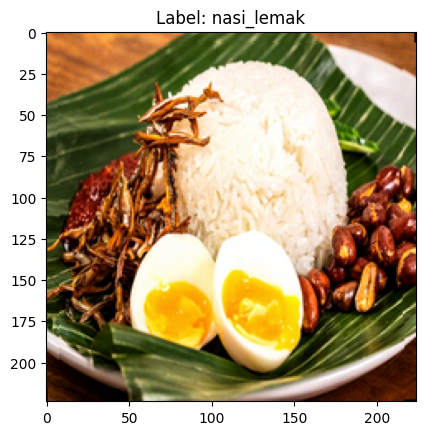

In [5]:
idx = 14
view_image(images[idx], names[idx])

In [15]:
train_outliers_dataset = TrainOutliersDataset('../data/')
train_outlier_dataloader = DataLoader(train_outliers_dataset, batch_size=16, shuffle=True)

2279 images


In [16]:
data_iter = iter(train_outlier_dataloader)
images, _ = next(data_iter)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


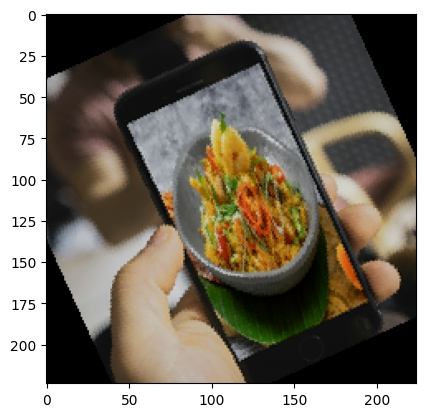

In [19]:
idx = 4
view_image(images[idx])

In [9]:
test_dataset = TestDataset('../data/',include_outliers=False)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

455 images


In [10]:
data_iter = iter(test_dataloader)
images, labels, names, _ = next(data_iter)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


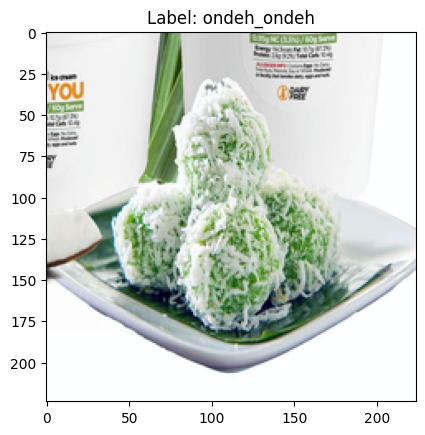

In [11]:
idx = 1
view_image(images[idx], names[idx])

## Train Model

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import numpy as np
import torch.nn.functional as F

class MobileNetV2(nn.Module):
    def __init__(self, num_classes=30):
        super(MobileNetV2, self).__init__()
        self.model = models.mobilenet_v2(pretrained=True)
        self.model.classifier[1] = nn.Linear(self.model.last_channel, num_classes)

    def forward(self, x):
        return self.model(x)

In [23]:
model = MobileNetV2().to('cuda')

epochs = 20

optimizer = torch.optim.SGD(model.parameters(), 0.001, momentum=0.9, nesterov=True)

def cosine_annealing(step, total_steps, lr_max, lr_min):
    return lr_min + (lr_max - lr_min) * 0.5 * (
            1 + np.cos(step / total_steps * np.pi))

scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda step: cosine_annealing(
        step,
        epochs * len(train_food_dataloader),
        1, 
        1e-8))

In [24]:
def train():
    model.train()  
    loss_avg = 0.0

    for in_set, out_set in zip(train_food_dataloader, train_outlier_dataloader):
        data = torch.cat((in_set[0], out_set[0]), 0)
        target = in_set[1]

        data, target = data.to('cuda'), target.to('cuda')

        x = model(data)

        scheduler.step()
        optimizer.zero_grad()

        loss = F.cross_entropy(x[:len(in_set[0])], target)
        # cross-entropy from softmax distribution to uniform distribution
        loss += 0.5 * -(x[len(in_set[0]):].mean(1) - torch.logsumexp(x[len(in_set[0]):], dim=1)).mean()

        loss.backward()
        optimizer.step()

        loss_avg = loss_avg * 0.8 + float(loss) * 0.2

    return loss_avg

In [25]:
def test():
    model.eval()
    loss_avg = 0.0
    correct = 0
    with torch.no_grad():
        for data, target, _, _ in test_dataloader:
            data, target = data.cuda(), target.cuda()

            output = model(data)
            loss = F.cross_entropy(output, target)

            pred = output.data.max(1)[1]
            correct += pred.eq(target.data).sum().item()

            loss_avg += float(loss.data)

    test_loss = loss_avg / len(test_dataloader)
    test_acc = correct / len(test_dataloader.dataset)
    return test_loss, test_acc

In [ ]:
import time

version = "v_2_1"

start_epoch = 0

for epoch in range(start_epoch, start_epoch+epochs):
    begin_epoch = time.time()

    loss_avg = train()
    test_loss, test_acc = test()

    # Save model
    torch.save(model.state_dict(),
               os.path.join('artifacts', 'model_' + version + '_epoch_' + str(epoch) + '.pt'))
    
    # Let us not waste space and delete the previous model
    # prev_path = os.path.join(args.save, calib_indicator + 'model_epoch' + str(epoch - 1) + '.pt')
    # if os.path.exists(prev_path): os.remove(prev_path)

    # Show results

    with open(os.path.join('artifacts', f'training_result_{version}.csv'), 'a') as f:
        f.write('%03d,%05d,%0.6f,%0.5f,%0.2f\n' % (
            (epoch + 1),
            time.time() - begin_epoch,
            loss_avg,
            test_loss,
            100. * test_acc,
        ))

    # # print state with rounded decimals
    # print({k: round(v, 4) if isinstance(v, float) else v for k, v in state.items()})

    print('Epoch {0:3d} | Time {1:5d} | Train Loss {2:.4f} | Test Loss {3:.3f} | Test Accuracy {4:.2f}'.format(
        (epoch + 1),
        int(time.time() - begin_epoch),
        loss_avg,
        test_loss,
        100. * test_acc,
    ))